# Smart City Optimisation 

In [75]:
import sqlite3
import pandas as pd
import os

In [76]:
# Load CSV file
df = pd.read_csv('../Data/energydata_complete.csv')
print(f"Loaded CSV: {len(df)} rows")



Loaded CSV: 19735 rows


In [77]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [78]:
# Split into two tables
df_energy = df[[
    'date', 
    'Appliances', 
    'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9'  # Room temperatures
]].rename(columns={
    'Appliances': 'appliances_energy'
})

# Add lights column to energy data
df_energy['lights'] = df['lights']

# Weather columns (corrected names)
df_weather = df[[
    'date', 
    'T_out', 
    'Press_mm_hg',  
    'RH_out', 
    'Windspeed'     
]]

print("Energy table columns:", df_energy.columns.tolist())
print("Weather table columns:", df_weather.columns.tolist())

Energy table columns: ['date', 'appliances_energy', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'lights']
Weather table columns: ['date', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed']


In [79]:
# Create SQLite Database
import sqlite3

# Connect to SQLite
conn = sqlite3.connect('../sql/smart_city.db')

# Create tables
df_energy.to_sql('energy_consumption', conn, if_exists='replace', index=False)
df_weather.to_sql('weather', conn, if_exists='replace', index=False)

print("Database created successfully!")

Database created successfully!


In [80]:
# Verify Database
# Check tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables in database:", cursor.fetchall())

# Check sample data
print("\nEnergy consumption sample:")
print(pd.read_sql_query("SELECT * FROM energy_consumption LIMIT 3", conn))

print("\nWeather sample:")
print(pd.read_sql_query("SELECT * FROM weather LIMIT 3", conn))

Tables in database: [('energy_consumption',), ('weather',)]

Energy consumption sample:
                  date  appliances_energy     T1    T2     T3         T4  \
0  2016-01-11 17:00:00                 60  19.89  19.2  19.79  19.000000   
1  2016-01-11 17:10:00                 60  19.89  19.2  19.79  19.000000   
2  2016-01-11 17:20:00                 50  19.89  19.2  19.79  18.926667   

          T5        T6    T7    T8         T9  lights  
0  17.166667  7.026667  17.2  18.2  17.033333      30  
1  17.166667  6.833333  17.2  18.2  17.066667      30  
2  17.166667  6.560000  17.2  18.2  17.000000      30  

Weather sample:
                  date     T_out  Press_mm_hg  RH_out  Windspeed
0  2016-01-11 17:00:00  6.600000        733.5    92.0   7.000000
1  2016-01-11 17:10:00  6.483333        733.6    92.0   6.666667
2  2016-01-11 17:20:00  6.366667        733.7    92.0   6.333333


In [81]:
# Connect to Database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Connect to SQLite database
conn = sqlite3.connect('../sql/smart_city.db')

print("Database connected successfully!")

Database connected successfully!


In [82]:
# Basic JOIN query
query = """
SELECT 
    e.date,
    e.appliances_energy as energy_kwh,
    w.T_out as temperature_c,
    w.RH_out as humidity_percent,
    w.Press_mm_hg as pressure
FROM energy_consumption e
JOIN weather w ON e.date = w.date
LIMIT 10
"""

df = pd.read_sql_query(query, conn)
print(df)

                  date  energy_kwh  temperature_c  humidity_percent  \
0  2016-01-11 17:00:00          60       6.600000         92.000000   
1  2016-01-11 17:10:00          60       6.483333         92.000000   
2  2016-01-11 17:20:00          50       6.366667         92.000000   
3  2016-01-11 17:30:00          50       6.250000         92.000000   
4  2016-01-11 17:40:00          60       6.133333         92.000000   
5  2016-01-11 17:50:00          50       6.016667         92.000000   
6  2016-01-11 18:00:00          60       5.900000         92.000000   
7  2016-01-11 18:10:00          60       5.916667         91.833333   
8  2016-01-11 18:20:00          60       5.933333         91.666667   
9  2016-01-11 18:30:00          70       5.950000         91.500000   

     pressure  
0  733.500000  
1  733.600000  
2  733.700000  
3  733.800000  
4  733.900000  
5  734.000000  
6  734.100000  
7  734.166667  
8  734.233333  
9  734.300000  


In [83]:
# Daily analysis
q_full = """
SELECT 
    e.date,
    e.appliances_energy,
    w.T_out,
    w.RH_out
FROM energy_consumption e
JOIN weather w ON e.date = w.date
"""
df_viz = pd.read_sql_query(q_full, conn)
df_viz['date'] = pd.to_datetime(df_viz['date'])


df_viz['day'] = df_viz['date'].dt.date  

df_daily = (
    df_viz
    .groupby('day')
    .agg(
        avg_daily_energy=('appliances_energy', 'mean'),
        avg_daily_temp=('T_out', 'mean'),
        avg_daily_humidity=('RH_out', 'mean')
    )
    .reset_index()
)

df_daily['day'] = pd.to_datetime(df_daily['day'])

print("df_daily shape:", df_daily.shape)
print(df_daily.head())
print("Number of unique days:", df_daily['day'].nunique())

df_daily shape: (138, 4)
         day  avg_daily_energy  avg_daily_temp  avg_daily_humidity
0 2016-01-11        136.666667        5.922619           89.285714
1 2016-01-12         85.694444        5.566319           87.500000
2 2016-01-13         97.013889        4.856944           83.406250
3 2016-01-14        151.388889        3.431944           86.420139
4 2016-01-15        125.347222        2.665278           88.385417
Number of unique days: 138


In [84]:
# Monthly analysis with CTE
q_monthly = """
WITH monthly_stats AS (
    SELECT 
        strftime('%Y', e.date) AS year,
        strftime('%m', e.date) AS month,
        AVG(e.appliances_energy) AS avg_energy,
        AVG(w.T_out) AS avg_temp,
        AVG(w.RH_out) AS avg_humidity
    FROM energy_consumption e
    JOIN weather w ON e.date = w.date
    GROUP BY strftime('%Y', e.date), strftime('%m', e.date)
)
SELECT
    year,
    month,
    avg_energy,
    avg_temp,
    avg_humidity
FROM monthly_stats
ORDER BY year, month;
"""

df_monthly = pd.read_sql_query(q_monthly, conn)
df_monthly.head()

,year,month,avg_energy,avg_temp,avg_humidity
0,2016,01,97.026010,4.128936,86.607461
1,2016,02,100.945881,4.817301,84.230125
2,2016,03,96.953405,5.439415,80.734991
3,2016,04,98.888889,8.513449,77.209954
4,2016,05,94.199325,13.762717,71.402673


In [85]:
#  High-energy records on cold days
q_high = """
SELECT 
    e.date,
    e.appliances_energy,
    e.lights,
    w.T_out,
    w.RH_out,
    e.appliances_energy / (w.T_out + 1.0) AS energy_per_degree
FROM energy_consumption e
JOIN weather w ON e.date = w.date
WHERE w.T_out < 15
ORDER BY e.appliances_energy DESC
LIMIT 10;
"""

df_high = pd.read_sql_query(q_high, conn)
df_high.head()

,date,appliances_energy,lights,T_out,RH_out,energy_per_degree
0,2016-01-16 18:50:00,1080,30,2.083333,85.500000,350.270270
1,2016-01-21 18:50:00,1070,30,-0.616667,82.833333,2791.304348
2,2016-01-14 17:00:00,910,0,4.600000,76.000000,162.500000
3,2016-04-04 15:40:00,900,0,14.766667,59.666667,57.082452
4,2016-01-21 19:00:00,890,20,-0.800000,84.000000,4450.000000


In [99]:
# Load data for visualisation

# Use df_daily from Phase 4 (monthly trends)
df_daily['day'] = pd.to_datetime(df_daily['day'])

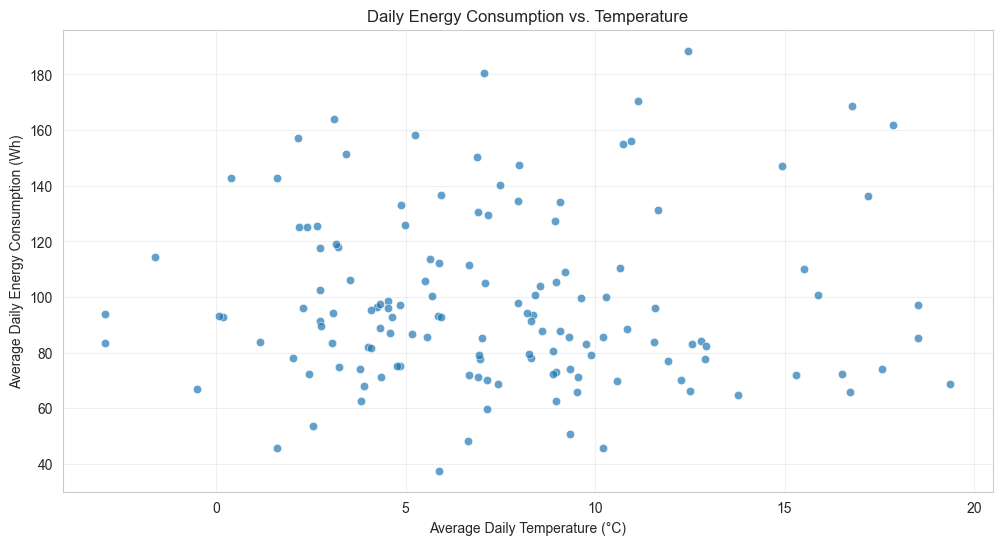

In [100]:
# Energy vs Temperature Scatter plot

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_daily,
    x='avg_daily_temp',
    y='avg_daily_energy',
    alpha=0.7
)
plt.title('Daily Energy Consumption vs. Temperature')
plt.xlabel('Average Daily Temperature (°C)')
plt.ylabel('Average Daily Energy Consumption (Wh)')
plt.grid(True, alpha=0.3)
plt.savefig('energy_vs_temp_daily.png', dpi=300, bbox_inches='tight')
plt.show()

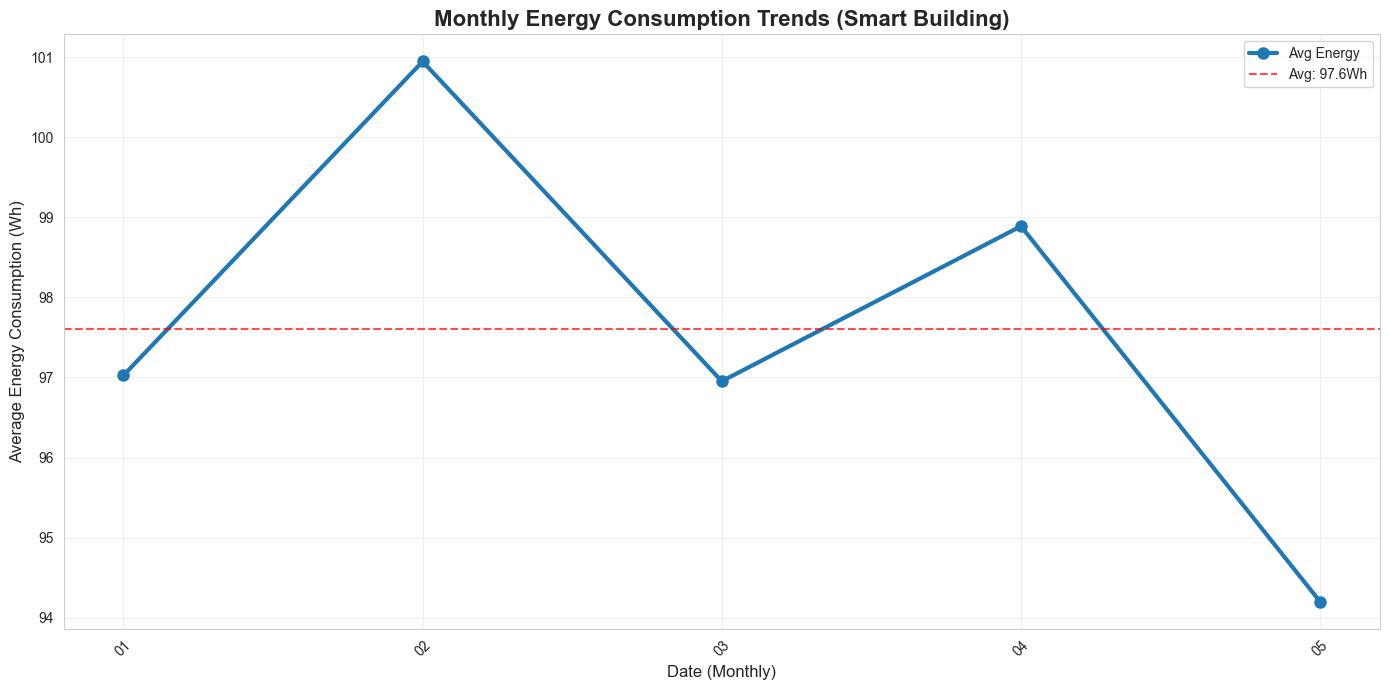

In [101]:
# Monthly Trends Line Plot

plt.figure(figsize=(14, 7))
plt.plot(df_monthly['month'], df_monthly['avg_energy'], 
         marker='o', linewidth=3, markersize=8, color='#1f77b4', label='Avg Energy')

# Add average line
avg_line = df_monthly['avg_energy'].mean()
plt.axhline(y=avg_line, color='red', linestyle='--', alpha=0.7, label=f'Avg: {avg_line:.1f}Wh')

plt.title('Monthly Energy Consumption Trends (Smart Building)', fontsize=16, fontweight='bold')
plt.xlabel('Date (Monthly)', fontsize=12)
plt.ylabel('Average Energy Consumption (Wh)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('enhanced_monthly_trends.png', dpi=300, bbox_inches='tight')
plt.show()

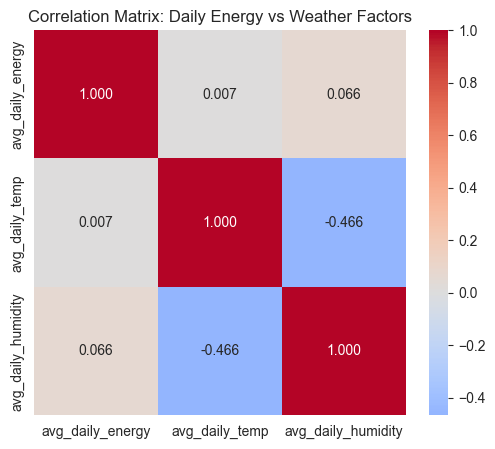

Correlation between daily Energy & Temperature: 0.00711089437249802


In [102]:
# Correlation Heatmap
corr_data = df_daily[['avg_daily_energy',
                      'avg_daily_temp',
                      'avg_daily_humidity']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Matrix: Daily Energy vs Weather Factors')
plt.savefig('correlation_heatmap_daily.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation between daily Energy & Temperature:",
      corr_data.loc['avg_daily_energy', 'avg_daily_temp'])

In [103]:
# Correlation Matrix

df_daily[['avg_daily_energy', 'avg_daily_temp', 'avg_daily_humidity']].corr()

,avg_daily_energy,avg_daily_temp,avg_daily_humidity
avg_daily_energy,1.000000,0.007111,0.065827
avg_daily_temp,0.007111,1.000000,-0.466368
avg_daily_humidity,0.065827,-0.466368,1.000000


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [105]:
# Prepare data for modeling

# Features and target
X = df_daily[['avg_daily_temp', 'avg_daily_humidity']]
y = df_daily['avg_daily_energy']

# Just in case there are any NaNs
mask = ~X.isna().any(axis=1) & ~y.isna()
X = X[mask]
y = y[mask]

print("Samples for modeling:", len(X))

Samples for modeling: 138


In [106]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 110 Test size: 28


In [107]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients
coef_temp, coef_hum = model.coef_
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficient (Temperature):", coef_temp)
print("Coefficient (Humidity):", coef_hum)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"\nTrain R²: {r2_train:.3f}")
print(f"Test R²:  {r2_test:.3f}")
print(f"Test MAE: {mae_test:.2f} Wh")

Intercept: 56.547595233250455
Coefficient (Temperature): 0.47883367191412207
Coefficient (Humidity): 0.46968123839702147

Train R²: 0.015
Test R²:  -0.051
Test MAE: 23.56 Wh


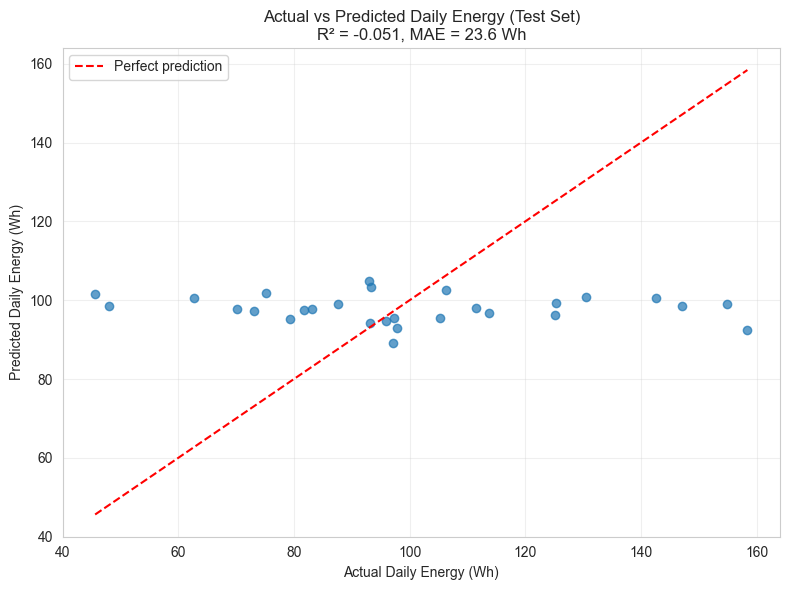

In [108]:
#Actual vs predicted plot

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
lim_min = min(y_test.min(), y_test_pred.min())
lim_max = max(y_test.max(), y_test_pred.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', label='Perfect prediction')

plt.xlabel('Actual Daily Energy (Wh)')
plt.ylabel('Predicted Daily Energy (Wh)')
plt.title(f'Actual vs Predicted Daily Energy (Test Set)\nR² = {r2_test:.3f}, MAE = {mae_test:.1f} Wh')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_pred_daily_energy.png', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
# Export the full joined dataset to CSV:
df_combined = pd.read_sql_query("""
SELECT 
    e.date,
    e.appliances_energy,
    w.T_out as avg_temp_c,
    w.RH_out as avg_humidity
FROM energy_consumption e
JOIN weather w ON e.date = w.date
""", conn)

df_combined.to_csv('../Data/final_smart_city_data.csv', index=False)
print("final_smart_city_data.csv saved")

final_smart_city_data.csv saved
